In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data=pd.read_csv('BostonHousing.csv')
df=pd.DataFrame(data)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV,CAT. MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0,0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6,0
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7,1
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4,1
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2,1


In [ ]:
df=df.drop(columns=['ZN','INDUS','CHAS','NOX','AGE','DIS','RAD','TAX','PTRATIO','LSTAT','CAT. MEDV'])
df.head()

,CRIM,RM,MEDV
0,0.00632,6.575,24.0
1,0.02731,6.421,21.6
2,0.02729,7.185,34.7
3,0.03237,6.998,33.4
4,0.06905,7.147,36.2


In [ ]:
x = df[['RM', 'CRIM']].values
y = df['MEDV'].values


In [ ]:
x_min=x.min(axis=0)
x_max=x.max(axis=0)
x_norm=(x-x_min)/(x_max-x_min)
y_min = y.min()
y_max = y.max()
y_norm = (y - y_min) / (y_max - y_min)


In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x_norm,y_norm,test_size=0.2, random_state=42)

In [ ]:
print("Training set :",x_train.shape,y_train.shape)
print("Testing set :",x_test.shape,y_test.shape)


Training set : (404, 2) (404,)
Testing set : (102, 2) (102,)


# Neural Network


In [ ]:
# basic activation functions like ReLU(x)=max(0,x)
def relu(Z):
  return np.maximum(0,Z)

def relu_derivative(Z):
  return (Z>0).astype(float)

# loss function (Mean Squared error)
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)


In [ ]:
def initialize_parameters():
    np.random.seed(42)
    return {
        "W1": np.random.randn(2, 5) * np.sqrt(2 / 2),
        "b1": np.zeros((1, 5)),

        "W2": np.random.randn(5, 3) * np.sqrt(2 / 5),
        "b2": np.zeros((1, 3)),

        "W3": np.random.randn(3, 1) * np.sqrt(2 / 3),
        "b3": np.zeros((1, 1))
    }


In [ ]:
# calculate the Y based on intial parameters
def forward_propagation(X, params):
  #layer1
    Z1 = X @ params["W1"] + params["b1"]
    A1 = relu(Z1)
  #layer2
    Z2 = A1 @ params["W2"] + params["b2"]
    A2 = relu(Z2)
  #layer#
    Z3 = A2 @ params["W3"] + params["b3"]  # Linear output
    y_hat = Z3

    cache = (X, Z1, A1, Z2, A2, Z3)
    return y_hat, cache


In [ ]:
#adjust the weight and biases parameters based on loss  function
def backward_propagation(y, y_hat, cache, params):
    X, Z1, A1, Z2, A2, Z3 = cache
    m = X.shape[0]

    dZ3 = (y_hat - y.reshape(-1,1)) / m
    dW3 = A2.T @ dZ3
    db3 = np.sum(dZ3, axis=0, keepdims=True)

    dA2 = dZ3 @ params["W3"].T
    dZ2 = dA2 * relu_derivative(Z2)
    dW2 = A1.T @ dZ2
    db2 = np.sum(dZ2, axis=0, keepdims=True)

    dA1 = dZ2 @ params["W2"].T
    dZ1 = dA1 * relu_derivative(Z1)
    dW1 = X.T @ dZ1
    db1 = np.sum(dZ1, axis=0, keepdims=True)

    grads = {
        "dW1": dW1, "db1": db1,
        "dW2": dW2, "db2": db2,
        "dW3": dW3, "db3": db3
    }

    return grads


In [ ]:
#basic gradient desent
def update_gd(params, grads, lr):
    for key in params:
        params[key] -= lr * grads["d" + key]
    return params

# momentum optimizer
def update_momentum(params, grads, v, lr, beta=0.9):
    for key in params:
        v[key] = beta * v[key] + (1 - beta) * grads["d" + key]
        params[key] -= lr * v[key]
    return params, v
# adam optimiser
def update_adam(params, grads, v, s, t, lr,
                beta1=0.9, beta2=0.999, eps=1e-8):

    for key in params:
        v[key] = beta1 * v[key] + (1 - beta1) * grads["d" + key]
        s[key] = beta2 * s[key] + (1 - beta2) * (grads["d" + key] ** 2)

        v_corr = v[key] / (1 - beta1**t)
        s_corr = s[key] / (1 - beta2**t)

        params[key] -= lr * v_corr / (np.sqrt(s_corr) + eps)

    return params, v, s




In [ ]:
#module to train the model
def train(X, y, epochs=1000, lr=0.01, optimizer="gd"):
    params = initialize_parameters()
    losses = []

    v = {k: np.zeros_like(params[k]) for k in params}
    s = {k: np.zeros_like(params[k]) for k in params}

    for epoch in range(1, epochs+1):
        y_hat, cache = forward_propagation(X, params)
        loss = mse(y, y_hat)
        losses.append(loss)

        grads = backward_propagation(y, y_hat, cache, params)

        if optimizer == "gd":
            params = update_gd(params, grads, lr)
        elif optimizer == "momentum":
            params, v = update_momentum(params, grads, v, lr)
        elif optimizer == "adam":
            params, v, s = update_adam(params, grads, v, s, epoch, lr)

        if epoch % 100 == 0:
            print(f"Epoch {epoch} | Loss: {loss:.4f}")

    return params, losses


In [ ]:
results = {}

optimizers = ["gd", "momentum", "adam"]
learning_rates = [0.01]

for opt in optimizers:
    for lr in learning_rates:
        key = f"{opt}_lr_{lr}"
        print(f"Training with {opt.upper()} | LR = {lr}")

        params, losses = train(
            x_train,
            y_train,
            epochs=1000,
            lr=lr,
            optimizer=opt
        )

        results[key] = {
            "params": params,
            "losses": losses
        }


Training with GD | LR = 0.01
Epoch 100 | Loss: 0.0532
Epoch 200 | Loss: 0.0438
Epoch 300 | Loss: 0.0430
Epoch 400 | Loss: 0.0429
Epoch 500 | Loss: 0.0429
Epoch 600 | Loss: 0.0429
Epoch 700 | Loss: 0.0429
Epoch 800 | Loss: 0.0429
Epoch 900 | Loss: 0.0429
Epoch 1000 | Loss: 0.0429
Training with MOMENTUM | LR = 0.01
Epoch 100 | Loss: 0.0492
Epoch 200 | Loss: 0.0434
Epoch 300 | Loss: 0.0430
Epoch 400 | Loss: 0.0429
Epoch 500 | Loss: 0.0429
Epoch 600 | Loss: 0.0429
Epoch 700 | Loss: 0.0429
Epoch 800 | Loss: 0.0429
Epoch 900 | Loss: 0.0429
Epoch 1000 | Loss: 0.0429
Training with ADAM | LR = 0.01
Epoch 100 | Loss: 0.0429
Epoch 200 | Loss: 0.0429
Epoch 300 | Loss: 0.0429
Epoch 400 | Loss: 0.0429
Epoch 500 | Loss: 0.0429
Epoch 600 | Loss: 0.0429
Epoch 700 | Loss: 0.0429
Epoch 800 | Loss: 0.0429
Epoch 900 | Loss: 0.0429
Epoch 1000 | Loss: 0.0429


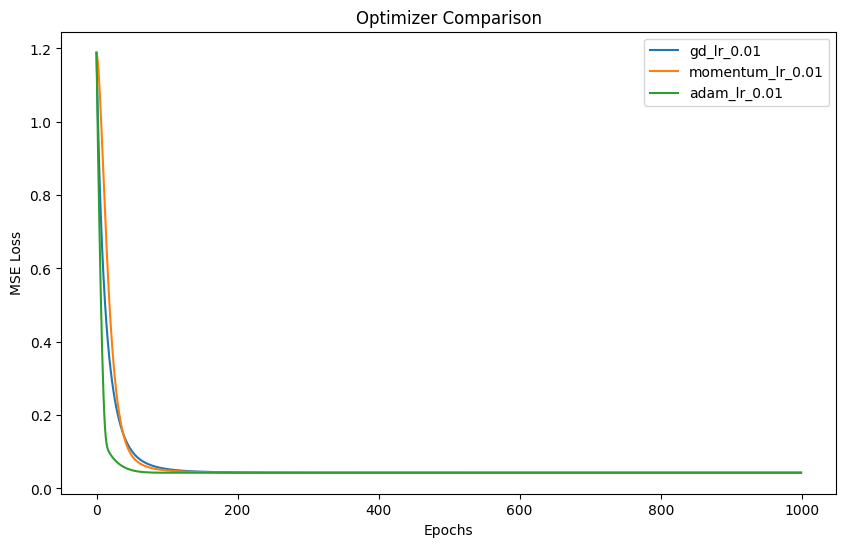

In [ ]:
plt.figure(figsize=(10,6))

for key in results:
    plt.plot(results[key]["losses"], label=key)

plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Optimizer Comparison")
plt.legend()
plt.show()


In [ ]:
for key in results:
    params = results[key]["params"]
    y_pred, _ = forward_propagation(x_test, params)
    test_loss = mse(y_test, y_pred)

    print(f"{key} | Test MSE: {test_loss:.4f}")


gd_lr_0.01 | Test MSE: 0.0371
momentum_lr_0.01 | Test MSE: 0.0371
adam_lr_0.01 | Test MSE: 0.0371


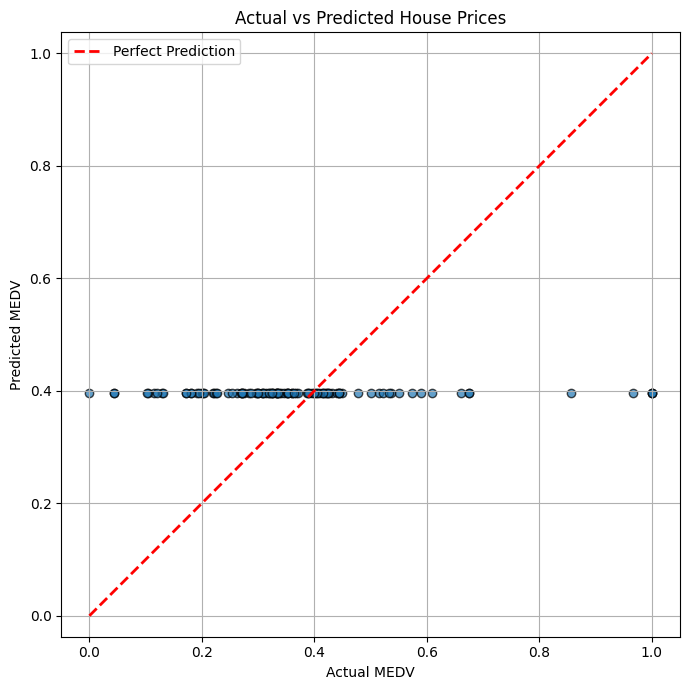

In [ ]:
plt.figure(figsize=(7, 7))

plt.scatter(
    y_test,
    y_pred,
    alpha=0.7,
    edgecolors='k'
)

# Perfect prediction line
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())

plt.plot(
    [min_val, max_val],
    [min_val, max_val],
    'r--',
    linewidth=2,
    label='Perfect Prediction'
)

plt.xlabel("Actual MEDV")
plt.ylabel("Predicted MEDV")
plt.title("Actual vs Predicted House Prices")

plt.axis('equal')   # IMPORTANT
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
print(y_test[:5])
print(y_pred[:5])


[0.41333333 0.60888889 0.19111111 0.39555556 0.24666667]
[[0.39547855]
 [0.39547855]
 [0.39547855]
 [0.39547855]
 [0.39547855]]


# Bonus


In [ ]:
def initialize_parameters_3hl():
    np.random.seed(42)
    return {
        "W1": np.random.randn(2, 5) * np.sqrt(2 / 2),
        "b1": np.zeros((1, 5)),

        "W2": np.random.randn(5, 3) * np.sqrt(2 / 5),
        "b2": np.zeros((1, 3)),

        "W3": np.random.randn(3, 2) * np.sqrt(2 / 3),
        "b3": np.zeros((1, 2)),

        "W4": np.random.randn(2, 1) * np.sqrt(2 / 2),
        "b4": np.zeros((1, 1))
    }


In [ ]:
def forward_propagation_3hl(X, params):
    Z1 = X @ params["W1"] + params["b1"]
    A1 = relu(Z1)

    Z2 = A1 @ params["W2"] + params["b2"]
    A2 = relu(Z2)

    Z3 = A2 @ params["W3"] + params["b3"]
    A3 = relu(Z3)

    Z4 = A3 @ params["W4"] + params["b4"]
    y_hat = Z4  # linear output

    cache = (X, Z1, A1, Z2, A2, Z3, A3, Z4)
    return y_hat, cache


In [ ]:
def backward_propagation_3hl(y, y_hat, cache, params):
    X, Z1, A1, Z2, A2, Z3, A3, Z4 = cache
    m = X.shape[0]

    dZ4 = (y_hat - y.reshape(-1,1)) / m
    dW4 = A3.T @ dZ4
    db4 = np.sum(dZ4, axis=0, keepdims=True)

    dA3 = dZ4 @ params["W4"].T
    dZ3 = dA3 * relu_derivative(Z3)
    dW3 = A2.T @ dZ3
    db3 = np.sum(dZ3, axis=0, keepdims=True)

    dA2 = dZ3 @ params["W3"].T
    dZ2 = dA2 * relu_derivative(Z2)
    dW2 = A1.T @ dZ2
    db2 = np.sum(dZ2, axis=0, keepdims=True)

    dA1 = dZ2 @ params["W2"].T
    dZ1 = dA1 * relu_derivative(Z1)
    dW1 = X.T @ dZ1
    db1 = np.sum(dZ1, axis=0, keepdims=True)

    return {
        "dW1": dW1, "db1": db1,
        "dW2": dW2, "db2": db2,
        "dW3": dW3, "db3": db3,
        "dW4": dW4, "db4": db4
    }


In [ ]:
#module to train the model
def train(X, y, epochs=1000, lr=0.01, optimizer="gd"):
    params = initialize_parameters_3hl()
    losses = []

    v = {k: np.zeros_like(params[k]) for k in params}
    s = {k: np.zeros_like(params[k]) for k in params}

    for epoch in range(1, epochs+1):
        y_hat, cache = forward_propagation_3hl(X, params)
        loss = mse(y, y_hat)
        losses.append(loss)

        grads = backward_propagation_3hl(y, y_hat, cache, params)

        if optimizer == "gd":
            params = update_gd(params, grads, lr)
        elif optimizer == "momentum":
            params, v = update_momentum(params, grads, v, lr)
        elif optimizer == "adam":
            params, v, s = update_adam(params, grads, v, s, epoch, lr)

        if epoch % 100 == 0:
            print(f"Epoch {epoch} | Loss: {loss:.4f}")

    return params, losses

In [ ]:
results = {}

optimizers = ["gd", "momentum", "adam"]
learning_rates = [0.01]

for opt in optimizers:
    for lr in learning_rates:
        key = f"{opt}_lr_{lr}"
        print(f"Training with {opt.upper()} | LR = {lr}")

        params, losses = train(
            x_train,
            y_train,
            epochs=1000,
            lr=lr,
            optimizer=opt
        )

        results[key] = {
            "params": params,
            "losses": losses
        }


Training with GD | LR = 0.01
Epoch 100 | Loss: 0.0626
Epoch 200 | Loss: 0.0637
Epoch 300 | Loss: 0.0647
Epoch 400 | Loss: 0.0657
Epoch 500 | Loss: 0.0665
Epoch 600 | Loss: 0.0672
Epoch 700 | Loss: 0.0679
Epoch 800 | Loss: 0.0686
Epoch 900 | Loss: 0.0692
Epoch 1000 | Loss: 0.0699
Training with MOMENTUM | LR = 0.01
Epoch 100 | Loss: 0.0625
Epoch 200 | Loss: 0.0636
Epoch 300 | Loss: 0.0647
Epoch 400 | Loss: 0.0656
Epoch 500 | Loss: 0.0665
Epoch 600 | Loss: 0.0672
Epoch 700 | Loss: 0.0679
Epoch 800 | Loss: 0.0686
Epoch 900 | Loss: 0.0692
Epoch 1000 | Loss: 0.0698
Training with ADAM | LR = 0.01
Epoch 100 | Loss: 0.0717
Epoch 200 | Loss: 0.0713
Epoch 300 | Loss: 0.0718
Epoch 400 | Loss: 0.0715
Epoch 500 | Loss: 0.0720
Epoch 600 | Loss: 0.0719
Epoch 700 | Loss: 0.0715
Epoch 800 | Loss: 0.0715
Epoch 900 | Loss: 0.0716
Epoch 1000 | Loss: 0.0716


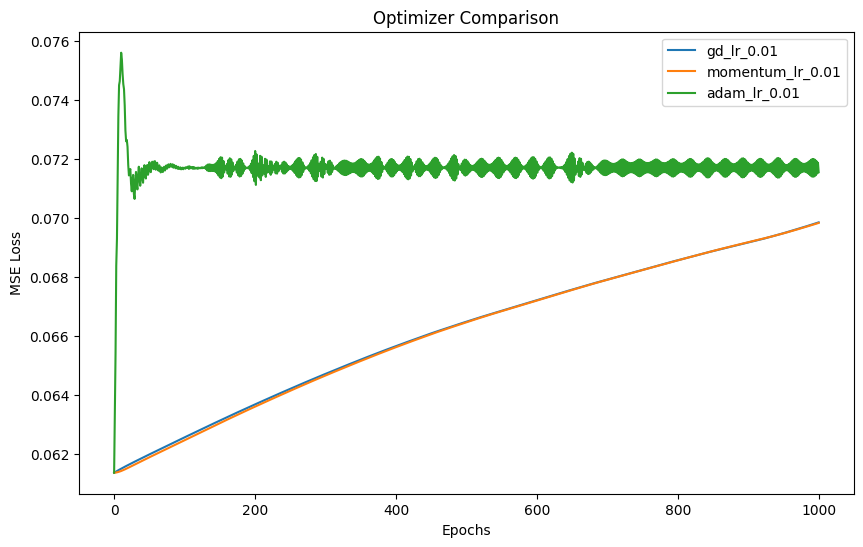

In [ ]:
plt.figure(figsize=(10,6))

for key in results:
    plt.plot(results[key]["losses"], label=key)

plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Optimizer Comparison")
plt.legend()
plt.show()


In [ ]:
for key in results:
    params = results[key]["params"]
    y_pred, _ = forward_propagation_3hl(x_test, params)
    test_loss = mse(y_test, y_pred)

    print(f"{key} | Test MSE: {test_loss:.4f}")

gd_lr_0.01 | Test MSE: 0.0570
momentum_lr_0.01 | Test MSE: 0.0570
adam_lr_0.01 | Test MSE: 0.0559


In [ ]:
print(y_test[:5])
print(y_pred[:5])

[0.41333333 0.60888889 0.19111111 0.39555556 0.24666667]
[[0.45204649]
 [0.53527669]
 [0.34749958]
 [0.36760695]
 [0.28875516]]


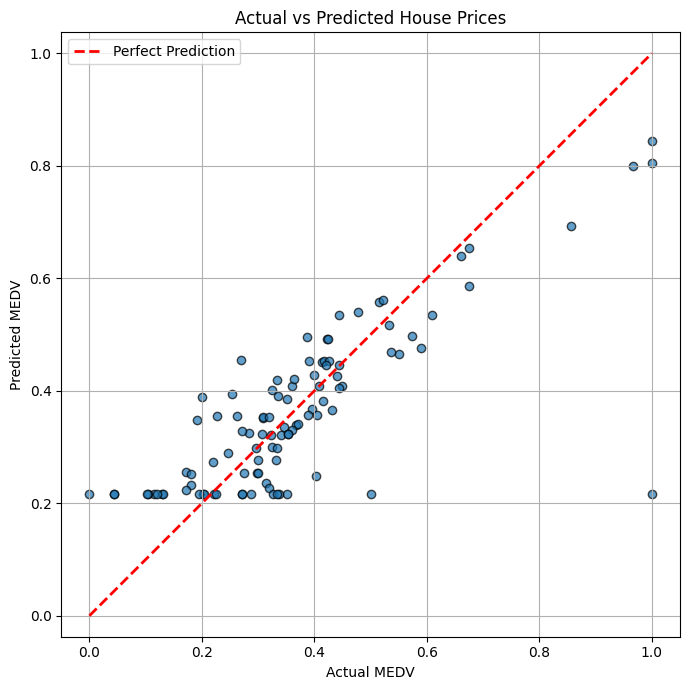

In [ ]:
plt.figure(figsize=(7, 7))

plt.scatter(
    y_test,
    y_pred,
    alpha=0.7,
    edgecolors='k'
)

# Perfect prediction line
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())

plt.plot(
    [min_val, max_val],
    [min_val, max_val],
    'r--',
    linewidth=2,
    label='Perfect Prediction'
)

plt.xlabel("Actual MEDV")
plt.ylabel("Predicted MEDV")
plt.title("Actual vs Predicted House Prices")

plt.axis('equal')   # IMPORTANT
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
